# HW5 Solutions

## 1 GMO

1. GMO’s approach.

**(a) Why does GMO believe they can more easily predict long-run than short-run asset class
performance?**

**Solution**: They believe that in the long-run, the market is a “weighting machine”, in that prices are
determined by economic fundamentals. Thus, as a macro-strategy fund, they believe their
economic info can predict long-run returns but that short-run returns can be influenced
substantially by behavioral trading.

**(b) What predicting variables does the case mention are used by GMO? Does this fit with the
goal of long-run forecasts?**

**Solution**: The case discusses price-earnings and price-dividend ratios in some detail. Given the high
serial correlation in these variables, it is no surprise that GMO think s their predictive
power is stronger over long-run horizons

**(c) How has this approach led to contrarian positions?**

**Solution**: GMO is, in a macro sense, a value investor. They invest in asset classes with low prices
per cash flow. This means that they are buying into depressed assets and missing out on
assets with large run-ups in price. The case mentions that as GMO missed the bull market
of the late 1990?s, they experienced large withdrawals before ultimately being proven right
in the crash of 2000-2001.

**(d) How does this approach raise business risk and managerial career risk?**

**Solution**:GMO’s contrarian positions put it in some funding risk. If they deviate too much from
other funds during strong performance, clients may want to withdraw money. (Of course,
if GMO can survive, they can show strong performance when other funds are not doing
well.) This is exactly what happened in the late 1990’s.
This same effect impacts managers, who may be rated as missing strong run-ups even if
their contrarian strategy will pay off in the long run.


### 2. The market environment.

**(a) We often estimate the market risk premium by looking at a large sample of historic data.
What reasons does the case give to be skeptical that the market risk premium will be as
high in the future as it has been over the past 50 years?**

**Solution**: The case shows that the price-dividend and price-earning ratios are much higher than their
historic average. This decades-long rise in prices-per-cashflow increased returns, but there
seems to be little room for further gains in P/D and P/E ratios.


**(b) In 2007, GMO forecasts real excess equity returns will be negative. What are the biggest
drivers of their pessimistic conditional forecast relative to the unconditional forecast. (See
Exhibit 9.)**

**Solution**: The two biggest drivers of the negative conditional forecast versus the unconditional forecast
are the expected decline in the dividend-price ratio and the decline in profit margin

**(c) In the 2011 forecast, what components has GMO revised most relative to 2007? Now**

**Solution**: Relative to 2007, the 2011 forecast revises expected bond returns down substantially (from
2% to 0.1%,) while revising expected dividend-price contraction to 0%.

### 3. Consider the asset class forecasts in Exhibit 1.

**(a) Which asset class did GMO estimate to have a negative 10-year return over 2002-2011?**

**Solution**: U.S. Equities is the only class with a negative outlook over that period.

**(b) Which asset classes substantially outperformed GMO’s estimate over that time period?**

**Solution**: While many asset classes outperformed, foreign-government bonds seemed to outperform
the most.

**(c) Which asset classes substantially underperformed GMO’s estimate over that time period?**

**Solution**: U.S. Real Estate and U.S. Tbills are the only classes which under-performed GMO’s estimates.


### 4. Fund Performance.

**(a) In which asset class was GMWAX most heavily allocated throughout the majority of 1997-
2011?**

**Solution**: Based on the chart, through most of the period GMWAX was most heavily allocated in
U.S. Fixed Income.

**(b) Comment on the performance of GMWAX versus its benchmark. (No calculation needed;
simply comment on the comparison in the exhibits.)**

**Solution**: The fund has been quite successful relative to the benchmark, with returns almost double
the benchmark and a Sharpe ratio more than double. We don?t have a long enough series
of returns to do a more involved statistical analysis of the performance.


## 2 Forecasting Returns

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display
sns.set()

pd.set_option('display.float_format', lambda x: '%.4f' % x)


path = 'grantham_data.xlsx'
df_rets = pd.read_excel(path, sheet_name='rets')
df_rets = df_rets.rename(columns={'DATE': 'dates'}).set_index('dates')

df_EP = pd.read_excel(path, sheet_name='EP')
df_EP = df_EP.rename(columns={' ':'dates'}).set_index('dates')

df = df_rets.join(df_EP) # now to join two dataframe together by date, in the single dataframe df
df['tilde_r_mkt'] = df['MKT'] - df['RF']
df['tilde_r_gmo'] = df['GMWAX'] - df['RF']

In [3]:
############
## Section 2
############

## Problem 2.1
##############
# Estimate the weights to the two dynamic strategies...

'''
They both are based on the subsample going from period 0 to t
So needed to be updated for every cell rolling from top to down

========= The only difference is how they calculate the conditional expectation, simply by sample average
or regression of the market return performance over the market earnings per share =======================

'''

df['cond_ave_MKT_t'] = np.nan
for date in df.index:
    df.loc[date, 'cond_ave_MKT_t'] = df.loc[:date, 'tilde_r_mkt'].mean() # like rolling from top to down, to calculate the mean value
    df.loc[date, 'cond_var_MKT_t'] = df.loc[:date, 'tilde_r_mkt'].var() # same here, rolling from top to down, to calculate the variance

'''
The regression function is r_t+1 = a + b*x_t, so that y exceeds x above 1 unit
'''

df['cond_reg_MKT_T'] = np.nan
df['reg_MKT_r_squared'] = np.nan
min_observations = 2

for date in df.index[min_observations:]: # the min_observation is 2? # Note that date = df.index[i]
    rhs = sm.add_constant(df.loc[:date,'EP'].shift(1))

    # EP: Earning Price, now you're shifting downward 1 unit of 'EP'
    # Because you're using the previous x to predict the current y

    lhs = df.loc[:date, 'tilde_r_mkt']
    res = sm.OLS(lhs, rhs, missing='drop').fit()
    #predict_ret = res.predict(df.loc[date, 'EP'])[0]
    predict_ret = res.predict([1, df.loc[date, 'EP']])[0]

    df.loc[date, 'cond_reg_MKT_T'] = predict_ret
    df.loc[date, 'reg_MKT_r_squared'] = res.rsquared
    df.loc[date, 'Alpha'] = res.params['const']
    df.loc[date, 'Beta'] = res.params['EP']

## (a) Use (1), (4), and (6) to build weights...
## This is just the sample average market returns
df['weight_o'] = 1/8 * df['cond_ave_MKT_t'] / df['cond_var_MKT_t']
df['tilde_ret_o'] = df['weight_o'].shift(1) * df['tilde_r_mkt']
display(df['tilde_ret_o'])


dates
1948-01-31       nan
1948-02-29       nan
1948-03-31   -0.0673
1948-04-30    0.0297
1948-05-31    0.0508
               ...  
2020-06-30    0.0080
2020-07-31    0.0360
2020-08-31    0.0431
2020-09-30   -0.0258
2020-10-31   -0.0154
Name: tilde_ret_o, Length: 874, dtype: float64

In [4]:
df.head()

,RF,MKT,GMWAX,EP,tilde_r_mkt,tilde_r_gmo,cond_ave_MKT_t,cond_var_MKT_t,cond_reg_MKT_T,reg_MKT_r_squared,Alpha,Beta,weight_o,tilde_ret_o
dates,,,,,,,,,,,,,,
1948-01-31,0.0008,-0.0445,nan,0.1108,-0.0453,nan,-0.0453,nan,nan,nan,nan,nan,nan,nan
1948-02-29,0.0008,0.0192,nan,0.1189,0.0184,nan,-0.0135,0.0020,nan,nan,nan,nan,-0.8300,nan
1948-03-31,0.0008,0.0819,nan,0.1196,0.0810,nan,0.0180,0.0040,0.0862,1.0000,-0.8388,7.7353,0.5655,-0.0673
1948-04-30,0.0008,0.0533,nan,0.1143,0.0525,nan,0.0267,0.0030,0.0388,0.7346,-0.5907,5.5085,1.1272,0.0297
1948-05-31,0.0008,0.0459,nan,0.1121,0.0450,nan,0.0303,0.0023,0.0289,0.7240,-0.5664,5.3115,1.6597,0.0508


In [5]:

## (b) Use (1), (5), and (6) to build weights...
## This is the regression of market returns over the market shares' EP

'''
Now we're using the weights from the EPs to construct the market portfolio
and to test the returns
'''

df['weight_x'] = 1/8 * df['cond_reg_MKT_T'] / df['cond_var_MKT_t']
df['tilde_ret_x'] = df['weight_x'].shift(1) * df['tilde_r_mkt']

df['tilde_ret_x']

dates
1948-01-31       nan
1948-02-29       nan
1948-03-31       nan
1948-04-30    0.1417
1948-05-31    0.0739
               ...  
2020-06-30    0.0045
2020-07-31    0.0183
2020-08-31    0.0222
2020-09-30   -0.0134
2020-10-31   -0.0078
Name: tilde_ret_x, Length: 874, dtype: float64

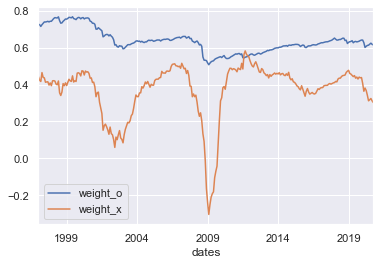

In [6]:
## (c) Plot the weights...What does this say about the two strategies?

df.loc['1997':'2020',['weight_o', 'weight_x']].plot();



In [7]:
## (d) Report the r-squared from the first regression, (data through Dec 1996),
# the full-sample regression, (data through Dec 2017,) and the average r-squared from
# all the regressions.
# Note that when doing the regression, we're rolling down continuously

print(df.loc['Dec 1996','reg_MKT_r_squared'])

print(df.loc['Oct 2020','reg_MKT_r_squared'])

print(df.loc['Dec 1996':'Oct 2020', 'reg_MKT_r_squared'].mean())



dates
1996-12-31   0.0067
Name: reg_MKT_r_squared, dtype: float64
dates
2020-10-31   0.0048
Name: reg_MKT_r_squared, dtype: float64
0.0067021626209880615


R^2 是相关系数的平方，代表拟合优度，表示因变量在这个回归模型中可以被自变量所解释的程度，一般越高，说明因变量可以被所选定的自变量越好地解释，拟合越好
Average of all regressions 0.0067
small, but this is for monthly data with a persistent regressor. Over annual data, we expect the
r-squared to be significantly larger.

In [8]:
## (e) Compare the following stats for the two strategies, as well as the market and GMO
## Note here that GMO also has data_points right now
## So we now to compare the strategies between
# Purely market, Purely GMO
# market*weight_from_sample_return(similar to MV, higher mean, smaller variance, higher weights that time)
# market*weight_from_EP, when the Earnings is higher, smaller variance, the weights will be higher
table_2_1_e = pd.DataFrame(columns=['tilde_r_mkt', 'tilde_ret_o', 'tilde_ret_x', 'tilde_r_gmo'],
    index=['mean', 'std', 'corr_to_r_m', 'Sharpe_ratio', 'Treynor_ratio'])

df_sample = df.loc['Dec 1996':'Oct 2020', :]

for col in table_2_1_e.columns:
    table_2_1_e.loc['mean', col] = df_sample[col].mean() * 12
    table_2_1_e.loc['std', col] = df_sample[col].std() * np.sqrt(12)
    table_2_1_e.loc['corr_to_r_m', col] = df_sample[col].corr(df_sample['tilde_r_mkt'])
    table_2_1_e.loc['Sharpe_ratio', col] = table_2_1_e.loc['mean', col] / table_2_1_e.loc['std', col]
    rhs = sm.add_constant(df_sample['tilde_r_mkt'])
    lhs = df_sample[col]
    res = sm.OLS(lhs, rhs, missing='drop').fit()
    table_2_1_e.loc['Treynor_ratio', col] = table_2_1_e.loc['mean', col] / res.params['tilde_r_mkt']

table_2_1_e



,tilde_r_mkt,tilde_ret_o,tilde_ret_x,tilde_r_gmo
mean,0.0696,0.0415,0.0280,0.0464
std,0.1367,0.0868,0.0491,0.1016
corr_to_r_m,1.0000,0.9946,0.8317,0.4975
Sharpe_ratio,0.5093,0.4785,0.5708,0.4572
Treynor_ratio,0.0696,0.0658,0.0938,0.1257


In [9]:
## (f) Discuss the differences in the strategies.


**Solution**: 
The regression-based strategy...
因为regression strategy is allocating weights based on the EP/Earnings per Price, therefore it focuses less than
the market returns at this moment, 因为可能有一些目前股价较低但是Earnings per Price很高的证券，这时候Regression会赋予给他们较高的权重
从表现来看的话，tilde_ret_x表现出当前的mean/std都比market低，但是sharpe ratio较高。

• takes a much lower view of the market risk premium going forward.

• Accordingly, it puts much less weight on the market return, leading to lower mean and
lower volatility.

• The timing does lead to substantially less correlation with the market than occurs with the
sample-average strategy.

• This market timing leads to better Sharpe and Treynor ratios(Treynor Ratio is the Earnings per Market Beta to it,
remember market is the regressor here 此时市场数据是解释变量，资产returns是被解释变量。Treynor Ratio越高，说明你可以在diversify市场的情况下获得较高收益).

The sample-average strategy actually under-performs a static market strategy in terms of Sharpe
ratio, as it lowers its exposure to the market after big losses (which impact the sample average)
and increases exposure after big gains. This is the opposite of GMO’s contrarian strategy.
GMO has a slightly worse Sharpe ratio yet a much better Treynor ratio, as the strategy incurs
volatility but less market correlation.

* **从mean, Sharpe Ratio的角度来看，GMO的策略可以说稍微逊于市场，但是GMO和market strategy的相关性较低，以及更重要的是Treynor Ratio较高，说明它可以在不遵循
市场的情况下取得较好的收益。**


In [18]:
## Problem 2.2
##############
## GMO believes a risk premium is compensation for a security's tendency
# to lose money at "bad times." Let's consider risk characteristics.

## (a) For both strategies, the market, and GMO, calculate the monthly VaR ...
# Monthly VaR is the lower bound for the return quantile
print('The data from 1996 to 2020 is as below:')
df.loc['Dec 1996':'Oct 2020', ['tilde_ret_o', 'tilde_ret_x', 'tilde_r_mkt', 'tilde_r_gmo']].apply(lambda x: x.quantile(0.05))

The data from 1996 to 2020 is as below:


tilde_ret_o   -0.0397
tilde_ret_x   -0.0229
tilde_r_mkt   -0.0649
tilde_r_gmo   -0.0417
dtype: float64

In [11]:
## (b) The GMO case mentions that stocks under-performed short-term bonds from
# 2000-2001. Does the dynamic portfolio above under-perform the risk-free rate
# over this time?
print('The Data from 2000 to 2011 is below:')
df.loc['2000':'2011', ['tilde_r_mkt', 'tilde_r_gmo', 'tilde_ret_o', 'tilde_ret_x']].mean() * 12

The Data from 2000 to 2011 is below:


tilde_r_mkt   -0.0012
tilde_r_gmo    0.0434
tilde_ret_o   -0.0073
tilde_ret_x   -0.0036
dtype: float64

**Solution**:
GMO being contrarian stands out during the negative excess return period of 2000-2011,
where GMO is up over 43% in cumulative excess return.

• The dynamic strategies show similar under-performance to the market.
Though the underperformance looks nominally better for the dynamic regression-based strategy, scaled by
overall volatility it is roughly the same. (i.e. The VaR is roughly the same number of
standard deviations for both.)

• The dynamic regression-based strategy at times predicts negative market returns, whereas
the sample average strategy (understandably) never does. (Because the negative return -- negative weights?)

In [12]:
## (c) Based on the regression estimates, in how many periods do we estimate...
## ???
min_periods = df[: '1996-12'].shape[0]
df_sample['Eo'] = df.tilde_r_mkt.expanding(min_periods = min_periods).mean()
df_sample['Ex'] = df_sample.Alpha + df_sample.Beta * df.EP

df_sample[['Ex', 'Eo']].apply(lambda s: (s<0).sum())

<ipython-input-12-babb904c1a48>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['Eo'] = df.tilde_r_mkt.expanding(min_periods = min_periods).mean()
<ipython-input-12-babb904c1a48>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sample['Ex'] = df_sample.Alpha + df_sample.Beta * df.EP


Ex    11
Eo     0
dtype: int64

In [13]:
## (d) Do you believe increased risk is behind the out-performance of \tilde r^x
# and \tilde r^{gmo}?

df_sample.tail()

,RF,MKT,GMWAX,EP,tilde_r_mkt,tilde_r_gmo,cond_ave_MKT_t,cond_var_MKT_t,cond_reg_MKT_T,reg_MKT_r_squared,Alpha,Beta,weight_o,tilde_ret_o,weight_x,tilde_ret_x,Eo,Ex
dates,,,,,,,,,,,,,,,,,,
2020-06-30,0.0001,0.0133,0.0220,0.0320,0.0132,0.0219,0.0061,0.0013,0.0031,0.0051,0.0004,0.0840,0.6128,0.0080,0.3116,0.0045,0.0061,0.0031
2020-07-31,0.0001,0.0589,0.0347,0.0309,0.0588,0.0346,0.0062,0.0013,0.0032,0.0048,0.0007,0.0814,0.6180,0.0360,0.3181,0.0183,0.0062,0.0032
2020-08-31,0.0001,0.0698,0.0172,0.0293,0.0697,0.0171,0.0063,0.0013,0.0033,0.0044,0.0010,0.0783,0.6237,0.0431,0.3243,0.0222,0.0063,0.0033
2020-09-30,0.0001,-0.0413,-0.0142,0.0295,-0.0414,-0.0142,0.0062,0.0013,0.0031,0.0047,0.0008,0.0805,0.6177,-0.0258,0.3119,-0.0134,0.0062,0.0031
2020-10-31,0.0001,-0.0249,-0.0094,0.0294,-0.0250,-0.0094,0.0062,0.0013,0.0030,0.0048,0.0006,0.0819,0.6143,-0.0154,0.3026,-0.0078,0.0062,0.0030


**Solution**: The risk profile of GMWAX is extremely different than that of the market return, making it
look even more attractive.
The risk profile of our dynamic strategies looks similar to the market but for the regression-based
strategy’s lower market correlation. But none of these stats make it look riskier than the static
market strategy, which leaves us to conclude it is an attractive strategy.


In [14]:
############
## Section 3
############

## Problem 3.1
# Re-do the analysis from the previous section, this time initiating it in
# 1967, with only 20 years of historic data and 50 years of trading data.

'''
To wrap up the above functionalities into a big function
'''

df_3_1_sample = df.loc['1967':,:].copy()

def create_return_series(dat, full_sample=False):
    dat['cond_ave_MKT_t'] = np.nan
    for date in dat.index:
        dat.loc[date, 'cond_ave_MKT_t'] = dat.loc[:date, 'tilde_r_mkt'].mean()
        dat.loc[date, 'cond_var_MKT_t'] = dat.loc[:date, 'tilde_r_mkt'].var()

    dat['cond_reg_MKT_T'] = np.nan
    dat['reg_MKT_r_squared'] = np.nan
    min_observations = 2 # min number of observations used in regression
    date = dat.index[1]
    for n, date in enumerate(dat.index[min_observations:]):
        i = n+min_observations # Note that date = dat.index[i]
        rhs = sm.add_constant(dat.loc[:date,'EP'].shift(1))
        lhs = dat.loc[:date, 'tilde_r_mkt']
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        predict_ret = res.predict([1,dat.loc[date, 'EP']])[0]
        dat.loc[date, 'cond_reg_MKT_T'] = predict_ret
        dat.loc[date, 'reg_MKT_r_squared'] = res.rsquared

    dat['weight_o'] = 1/8 * dat['cond_ave_MKT_t'] / dat['cond_var_MKT_t']
    dat['tilde_ret_o'] = dat['weight_o'].shift(1) * dat['tilde_r_mkt']

    dat['weight_x'] = 1/8 * dat['cond_reg_MKT_T'] / dat['cond_var_MKT_t']
    dat['tilde_ret_x'] = dat['weight_x'].shift(1) * dat['tilde_r_mkt']
    return dat

df_3_1_sample = create_return_series(dat=df_3_1_sample)

dat = df_3_1_sample.loc['Dec 1996':'Oct 2020', :]
def create_table(dat):
    table_2_1_e = pd.DataFrame(columns=['tilde_r_mkt', 'tilde_ret_o', 'tilde_ret_x', 'tilde_r_gmo'],
        index=['mean', 'std', 'corr_to_r_m', 'Sharpe_ratio', 'Treynor_ratio'])

    for col in table_2_1_e.columns:
        table_2_1_e.loc['mean', col] = dat[col].mean() * 12
        table_2_1_e.loc['std', col] = dat[col].std() * np.sqrt(12)
        table_2_1_e.loc['corr_to_r_m', col] = dat[col].corr(dat['tilde_r_mkt'])
        table_2_1_e.loc['Sharpe_ratio', col] = table_2_1_e.loc['mean', col] / table_2_1_e.loc['std', col]
        rhs = sm.add_constant(dat['tilde_r_mkt'])
        lhs = dat[col]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        table_2_1_e.loc['Treynor_ratio', col] = table_2_1_e.loc['mean', col] / res.params['tilde_r_mkt']

    return table_2_1_e

table_3_1 = create_table(dat)
table_3_1


,tilde_r_mkt,tilde_ret_o,tilde_ret_x,tilde_r_gmo
mean,0.0696,0.0267,0.0211,0.0464
std,0.1367,0.0566,0.0445,0.1016
corr_to_r_m,1.0000,0.9875,0.8500,0.4975
Sharpe_ratio,0.5093,0.4708,0.4729,0.4572
Treynor_ratio,0.0696,0.0652,0.0761,0.1257


In [15]:
df_3_1_sample.loc['2000':'2011', ['tilde_r_mkt', 'tilde_r_gmo', 'tilde_ret_o', 'tilde_ret_x']].mean() * 12

tilde_r_mkt   -0.0012
tilde_r_gmo    0.0434
tilde_ret_o   -0.0068
tilde_ret_x   -0.0090
dtype: float64

#### Problem 3.2
In the previous section, we were careful to build weights based on regression
estimates that would have been available at that time.
Re-do the analysis but run just one full-sample regression, 1948-2020,
and use these regression estimates for each periods weight. How much
does this inflate the performance of the strategy?

In [16]:
dat = df.copy()
dat['cond_ave_MKT_t'] = np.nan
for date in dat.index:
    dat.loc[date, 'cond_ave_MKT_t'] = dat.loc[:date, 'tilde_r_mkt'].mean()
    dat.loc[date, 'cond_var_MKT_t'] = dat.loc[:date, 'tilde_r_mkt'].var()

dat['cond_reg_MKT_T'] = np.nan
dat['reg_MKT_r_squared'] = np.nan

rhs = sm.add_constant(dat.loc[:,'EP'].shift(1))
lhs = dat.loc[:, 'tilde_r_mkt']
res = sm.OLS(lhs, rhs, missing='drop').fit()

for n, date in enumerate(dat.index):
    predict_ret = res.predict([1, dat.loc[date, 'EP']])[0]
    dat.loc[date, 'cond_reg_MKT_T'] = predict_ret
    dat.loc[date, 'reg_MKT_r_squared'] = res.rsquared

dat['weight_o'] = 1/8 * dat['cond_ave_MKT_t'] / dat['cond_var_MKT_t']
dat['tilde_ret_o'] = dat['weight_o'].shift(1) * dat['tilde_r_mkt']

dat['weight_x'] = 1/8 * dat['cond_reg_MKT_T'] / dat['cond_var_MKT_t']
dat['tilde_ret_x'] = dat['weight_x'].shift(1) * dat['tilde_r_mkt']

dat_sample = dat.loc['Dec 1996':'Oct 2020', :]
table_3_2 = create_table(dat_sample)

table_3_2

,tilde_r_mkt,tilde_ret_o,tilde_ret_x,tilde_r_gmo
mean,0.0696,0.0415,0.0351,0.0464
std,0.1367,0.0868,0.0578,0.1016
corr_to_r_m,1.0000,0.9946,0.9647,0.4975
Sharpe_ratio,0.5093,0.4785,0.6068,0.4572
Treynor_ratio,0.0696,0.0658,0.0860,0.1257


In [17]:
dat.loc['2000':'2011', ['tilde_r_mkt', 'tilde_r_gmo', 'tilde_ret_o', 'tilde_ret_x']].mean() * 12

tilde_r_mkt   -0.0012
tilde_r_gmo    0.0434
tilde_ret_o   -0.0073
tilde_ret_x    0.0022
dtype: float64